In [1]:
import sys
sys.path.append("../")

In [75]:
import os
import copy
import numpy as np
import pickle
from common.config import subdatasets
from common.dataloader import load_dataset
from IPython import embed


In [6]:
from matplotlib import pyplot as plt

Loading machine-1-1 of SMD dataset
.././datasets/anomaly/SMD/processed/machine-1-1_train.pkl
Shape of train is (750, 38).
Shape of test is (750, 38).
Shape of test_labels is (750,).
[Train] from (750, 38) to (10750, 38)
[Test] from (750, 38) to (10750, 38)
[Test Labels] from (750,) to (10750,)
20.903189 23.397823
Done, TY NB!


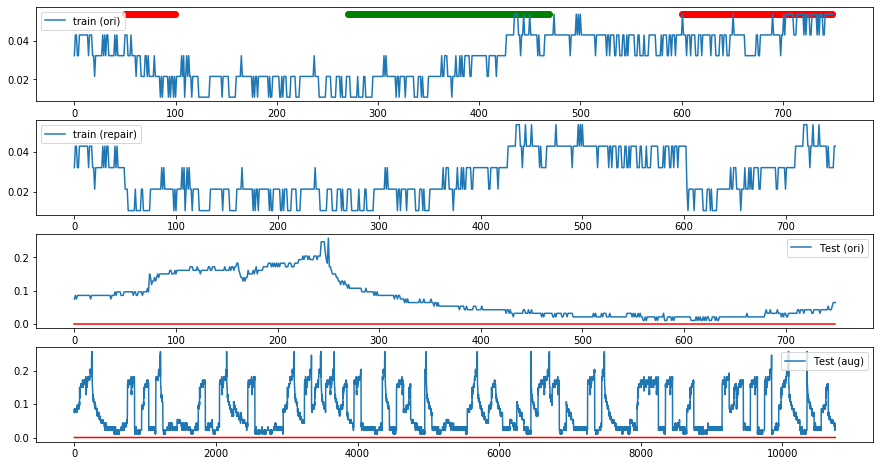

In [89]:
np.random.seed(2022)
anomaly_range = {"machine-1-1": [[50, 100], [850, 1000], [600, 800]]}

dataset = "SMD"  # modify this to HUAWEI
repeat_pattern_len = 100
repeat_num = 100

plot_figure=True

datapath = os.path.join(f"../datasets/anomaly/{dataset}_AUG")
os.makedirs(datapath, exist_ok=True)
for subdataset in subdatasets[dataset]:
    if subdataset not in anomaly_range: continue
    data_dict = load_dataset(dataset, subdataset, nrows=750)
    train_len = len(data_dict["train"])

    # modify wrong labels
    modify_ranges = set()
    for start, end in anomaly_range[subdataset]:
        if start < train_len:
            end_min = min(end, train_len)
            modify_ranges |= set(range(start, end_min))

    normal_indice = [idx for idx in range(train_len) if idx not in modify_ranges]
    rand_start = np.random.randint(0, len(normal_indice) - len(modify_ranges), size=1)[
        0
    ]
    rand_selection_indice = normal_indice[rand_start : rand_start + len(modify_ranges)]
    assert len(modify_ranges) == len(rand_selection_indice)

    original = copy.deepcopy(data_dict["train"])
    data_dict["train"][list(modify_ranges), :] = data_dict["train"][
        rand_selection_indice, :
    ]
    modified = copy.deepcopy(data_dict["train"])

        
    # data augmentation for train
    rand_start_list = np.random.randint(0, len(data_dict["train"]) - repeat_pattern_len, size=repeat_num)
    merged = [data_dict["train"]]
    for start in rand_start_list:
        merged.append(data_dict["train"][start: start+repeat_pattern_len])
    train_aug = np.vstack(merged)
    print("[Train] from {} to {}".format(data_dict["train"].shape, train_aug.shape))
    

    # data augmentation for test
    rand_start_list = np.random.randint(0, len(data_dict["test"]) - repeat_pattern_len, size=repeat_num)
    merged = [data_dict["test"]]
    merged_label = [data_dict["test_labels"]]
    for start in rand_start_list:
        merged.append(data_dict["test"][start: start+repeat_pattern_len])
        merged_label.append(data_dict["test_labels"][start: start+repeat_pattern_len])
    test_aug = np.vstack(merged)
    test_labels_aug = np.concatenate(merged_label)
    print("[Test] from {} to {}".format(data_dict["test"].shape, test_aug.shape))
    print("[Test Labels] from {} to {}".format(data_dict["test_labels"].shape, test_labels_aug.shape))
    
    
    if plot_figure:
        dim = 0
        fig, ax = plt.subplots(4, figsize=(15, 4*2))
        ax[0].plot(original[:, dim], label="train (ori)")
        ax[0].scatter(sorted(list(modify_ranges)), [max(original[:,dim])]*len(modify_ranges), c="r")
        ax[0].scatter(rand_selection_indice, [max(original[:,dim])]*len(modify_ranges), c="g")
        ax[0].legend()
        ax[1].plot(modified[:, dim], label="train (repair)")
        ax[1].legend()
        ax[2].plot(data_dict["test"][:, dim], label="Test (ori)")
        ax[2].plot(data_dict["test_labels"]*max(data_dict["test"][:, dim]), c="r")
        ax[2].legend()
        ax[3].plot(test_aug[:, dim], label="Test (aug)")
        ax[3].plot(test_labels_aug*max(test_aug[:, dim]), c="r")
        ax[3].legend()
        print(modified[:, dim].sum(), original[:, dim].sum())
        
        plot_figure = False # plot only once
        
        
    result = {
        "train": train_aug,
        "test": test_aug,
        "test_labels": test_labels_aug,
    }
    
    for k, v in result.items():
        with open(os.path.join(datapath, f"{subdataset}_{k}.pkl"), "wb") as fw:
            pickle.dump(v, fw)
    
    print("Done, TY NB!")